# Variational Autoencoder (VAE)
Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this seminar we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)

In [2]:
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset(dimx=36, dimy=36,
                                images_name="/mnt/mlhep2018/datasets/lfw-deepfunneled",
                                attrs_name="/mnt/mlhep2018/datasets/lfw_attributes.txt")
data = data.astype(np.float32) / 255.

In [3]:
def plot_gallery(images, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.axis('off')

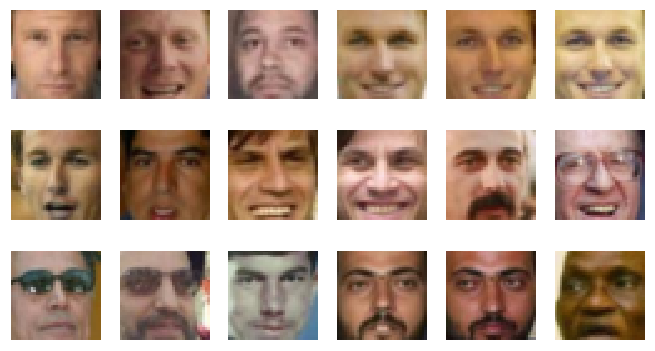

In [4]:
plot_gallery(data)

In [5]:
import tensorflow as tf
def get_tf_dataset(dataset, batch_size):
    """
    Produces an infinite stram of Tensorflow batches from a numpy dataset. The dataset is shuffled every epoch.
    Args:
       dataset: np.array[n_examples, ...]
       batch_size: int, batch size of the results
    Reuturns:
       Tensor, containing the next batch
    """
    if isinstance(dataset, tf.Tensor):
        N_EXAMPLES = dataset.shape[0]
    else:
        N_EXAMPLES = dataset[0].shape[0]
    shuffler = tf.contrib.data.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [6]:
import keras
from keras.models import Sequential, Model
from keras import layers as L

Using TensorFlow backend.


# Variational Autoencoder
Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. To do that we need to an encoder with two outputs. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Here we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [7]:
IMG_SHAPE = data.shape[1:]
CODE_SIZE = 128

In [8]:
encoder_activation = tf.nn.softplus

# Define the encoder to have an elegant pyramidal structure
# It first maps images into one pixel with many cahnnels
# Then flattens and uses a dense layer to get the CODE_SIZE outputs
FILTERS_N0 = 32
encoder = Sequential(name="Encoder")
encoder.add(L.InputLayer(IMG_SHAPE))
encoder.add(L.Conv2D(FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.Conv2D(int(1.5*FILTERS_N0), kernel_size=3, activation=encoder_activation))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Conv2D(2*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.Conv2D(3*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Conv2D(4*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.Conv2D(6*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Flatten())

# Having created a sequential model, we add two layers on top of its output
# Pay attention to the "Connected to" column in the summary
encoder_mu = L.Dense(CODE_SIZE, name="encoder_mu", activation=keras.activations.linear)(encoder.output)
encoder_log_sigma = L.Dense(CODE_SIZE, name="encoder_log_sigma", activation=keras.activations.linear)(encoder.output)

# Combines the sequential model and two layers into an two-headed model
image_to_mu_sigma_model = keras.Model(
    inputs=encoder.input,
    outputs=[encoder_mu, encoder_log_sigma])

print(image_to_mu_sigma_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 36, 36, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 34, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 48)   13872       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 48)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
# Create a decoder. It's a sequential model accepting a 1D vector of
# length CODE_SIZE inputs and outputting an image
# You may want to use a combination of Deconv2D, UpSampling2D
# An elegant solution is "invert" the encoder, switching
# Conv2D->Deconv2D MaxPool2D->UpSampling2D and reversing the layer order

def get_inverse_conv_layer_double(input, filtersno_1, filtersno_2):
    upsampling_1 = L.UpSampling2D(size=(2,2))(input)
    deconv_1a = L.Deconv2D(filtersno_1, kernel_size=3, activation=encoder_activation)(upsampling_1)
    deconv_1b = L.Deconv2D(filtersno_2, kernel_size=3, activation=encoder_activation)(deconv_1a)
    return deconv_1b


input = L.Input(shape=(CODE_SIZE,))

unflatten = L.Reshape(target_shape=(1, 1, CODE_SIZE))(input)

layer_1 = get_inverse_conv_layer_double(unflatten, 6*FILTERS_N0, 4*FILTERS_N0)
layer_2 = get_inverse_conv_layer_double(layer_1, 3*FILTERS_N0, 2*FILTERS_N0)
layer_3 = get_inverse_conv_layer_double(layer_2, 3, 3)

decoder = Model(input=input, outputs=[layer_3], name='decoder')

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 192)         221376    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 6, 6, 128)         221312    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 96)        110688    
__________

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., name="decoder", inputs=Tensor("in...)`


In [10]:
TRAIN_BATCH_SIZE = 128
train_data_tf, train_attrs_tf = get_tf_dataset(
    (data.astype(np.float32), attrs.values.astype(np.float32)), TRAIN_BATCH_SIZE)

In [11]:
train_data_tf

<tf.Tensor 'IteratorGetNext:0' shape=(?, 36, 36, 3) dtype=float32>

In [12]:
train_attrs_tf

<tf.Tensor 'IteratorGetNext:1' shape=(?, 73) dtype=float32>

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=C + \sum_{i=1}^{dimX} (x_i - f_i)^2 / h^2$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [13]:
# The Variational part of VAE. For training image, get mean and log(std)
train_mu, train_log_sigma = image_to_mu_sigma_model(train_data_tf)

# < Compute std aka sigma >
train_sigma = tf.exp(train_log_sigma)

# < Sample from normal distribution (tf.random.normal)>
sampled_noise = tf.random_normal(shape=(TRAIN_BATCH_SIZE,CODE_SIZE))
print(sampled_noise)

# < Scale and shift the sampled values >
modelled_noise = train_mu + sampled_noise * train_sigma
print(modelled_noise)

Tensor("random_normal:0", shape=(128, 128), dtype=float32)
Tensor("add:0", shape=(128, 128), dtype=float32)


In [14]:
print(train_mu)
print(train_log_sigma)

Tensor("model_1/encoder_mu/BiasAdd:0", shape=(?, 128), dtype=float32)
Tensor("model_1/encoder_log_sigma/BiasAdd:0", shape=(?, 128), dtype=float32)


In [15]:
decoded_train = decoder(modelled_noise)
# We average both over examples and dimensions to make
# the losses the same order of magnitude.
# It would have been closer to equations to sum
# overdimensions and average over examples
# The apporoaches are equal up to a constant,
# which gets adjusted in the formula for the total loss
mse_loss = tf.losses.mean_squared_error(
    train_data_tf,
    decoded_train
    )

kl_loss = -0.5 * tf.reduce_sum(
    1. + 2.*train_log_sigma - tf.square(train_mu) - tf.square(train_sigma)
    )

# Coefficients here are, unfortunately, heuristics
# If your model outputs distorted faces, you may want to increase KL_LOSS_COEFF
# If your model output lacks diversity, you may want to decrease KL_LOSS_COEFF
# KL_LOSS_COEFF = 1e-3
KL_LOSS_COEFF = 1e-6
total_loss = mse_loss + KL_LOSS_COEFF*kl_loss

In [16]:
generation_batch_size = tf.placeholder_with_default(3, [], name="generation_batch_size")
generated_image = decoder(tf.random_normal([generation_batch_size, CODE_SIZE]))

In [17]:
iteration_tf = tf.Variable(0)
optimization_op = tf.train.AdamOptimizer(1e-3).minimize(
    total_loss,var_list=image_to_mu_sigma_model.trainable_weights +
        decoder.trainable_weights,
    global_step=iteration_tf)

learning_summary = tf.summary.merge([
    tf.summary.scalar("kl_loss", kl_loss),
    tf.summary.scalar("mse_loss", mse_loss),
    tf.summary.scalar("total_loss", total_loss),
#     tf.summary.scalar("attrs_loss", attrs_loss),
    tf.summary.image("generated_image", generated_image)
])

In [18]:
config_tf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config_tf)
sess.run(tf.global_variables_initializer())

from tqdm import tnrange
import os

LOGDIR = os.path.join("/mnt/students-home", os.environ["USER"], "tensorflow-logs")
MODEL_NAME = "VAE_v1"
TOTAL_ITERATIONS = int(1e4)

train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
train_writer.add_graph(tf.get_default_graph())

for iteration in tnrange(TOTAL_ITERATIONS):
    summary, _ = sess.run([learning_summary, optimization_op])
    train_writer.add_summary(summary, iteration)

In [19]:
print(generated_image)
print(learning_summary)

Tensor("decoder_1/conv2d_transpose_6/Softplus:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("Merge/MergeSummary:0", shape=(), dtype=string)


In [ ]:
image_to_mu_sigma_model.save_weights('vaefaces_gpu.h5')

In [ ]:
decoder.save_weights('vaefaces_gpu_decoder.h5')

In [ ]:
decoder.save('vaefaces_gpu_decoder_fullmodel.hdf5')

In [ ]:
image_to_mu_sigma_model.save('vaefaces_gpu_encoder_fullmodel.hdf5')

In [20]:
saver = tf.train.Saver()
save_path = saver.save(sess, "/mnt/students-home/thomas.klijnsma/mlhep2/day3-Thu/vae_gpu_2.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: /mnt/students-home/thomas.klijnsma/mlhep2/day3-Thu/vae_gpu_2.ckpt


# Try to generate inline

INFO:tensorflow:Restoring parameters from /mnt/students-home/thomas.klijnsma/mlhep2/day3-Thu/vae_gpu_2.ckpt


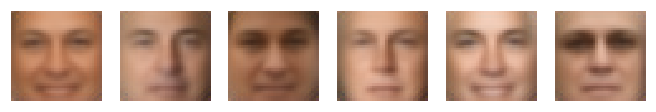

In [21]:
new_saver = tf.train.Saver()
with tf.Session() as new_sess:
    new_saver.restore(
        new_sess,
        # "/mnt/students-home/thomas.klijnsma/mlhep2/day3-Thu/vae_gpu_1.ckpt"
        '/mnt/students-home/thomas.klijnsma/mlhep2/day3-Thu/vae_gpu_2.ckpt'
        )
    numpy_images = new_sess.run(decoder(tf.random_normal([6, CODE_SIZE])))
    plot_gallery(numpy_images, n_row=1, n_col=6)

In [ ]:
numpy_images = sess.run(decoder(tf.random_normal([6, CODE_SIZE])))
plot_gallery(numpy_images, n_row=1, n_col=6)

In [ ]:
from keras.models import load_model
decoder_gpu = load_model('vaefaces_gpu_decoder_fullmodel.hdf5')
encoder_gpu = load_model('vaefaces_gpu_encoder_fullmodel.hdf5')

In [ ]:
with tf.Session() as new_sess:
    encoder_mu, encoder_log_sigma = encoder_gpu.predict(train_data_tf.eval())

In [ ]:
with tf.Session() as new_sess:
    new_sess.as_default()
    new_sess.run(tf.global_variables_initializer())
    encoder_mu, encoder_log_sigma = encoder_gpu(train_data_tf)
    new_noise = tf.random_normal([128, CODE_SIZE])
    shifted_noise = encoder_mu + new_noise * tf.exp(encoder_log_sigma)
    imgs = decoder_gpu(shifted_noise)
    numpy_images = new_sess.run(imgs)
    
# numpy_images = decoder_gpu(shifted_noise)
plot_gallery(numpy_images, n_row=1, n_col=6)

# Learning the true happiness

If you managed to tune your VAE to converge and learn something about the world, now it's time to move to more important matters. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: smiling faces and non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. 

## Tips and tricks

1) The ability of VAE to faithfully sample the faces distribution is adjusted via the coefficient before kl_loss in the total_loss formula. The higher value prioritizes the quality of sampled images and lower sample diversity and maintaining the relationship between the image and its encoding

2) When computing the representations of the sad and happy people, you may want to discard the sampling in the middle of VAE, only work with means and pass the means to decoder.

3) Since we want the latent representation to have a linear dependency with the features, you may want to add a linear model that predicts the attributes from the latent code and add its loss to the total loss with a small coefficient

In [ ]:
# We want to interact with our model, and will use this placeholder to pass
# images to decoder
input_images = tf.placeholder(tf.float32, (None, ) + IMG_SHAPE)

<img src="linear.png" alt="linear">